<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/SEED_7(GAN%2BBI_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pickle

In [2]:
df = pd.read_csv('/content/de_lds_with_labels(310 seed7).csv')

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=7)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape: (samples, 62 timesteps, 5 features)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)


In [3]:
def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    merged = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(62 * 5, activation='tanh')(x)
    x = tf.keras.layers.Reshape((62, 5))(x)
    return Model([noise_input, label_input], x)


def build_discriminator(input_shape, num_classes):
    data_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    x = tf.keras.layers.Flatten()(data_input)
    merged = Concatenate()([x, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(1, activation='sigmoid')(x)
    return Model([data_input, label_input], x)


latent_dim = 100
num_classes = 7
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((62, 5), num_classes)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Combined GAN
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))
generated_sample = generator([noise_input, label_input])
discriminator.trainable = False
validity = discriminator([generated_sample, label_input])
cgan = Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')


In [4]:
def train_gan(epochs=5000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict([noise, real_labels])

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_samples, real_labels], fake_y)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, real_labels], real_y)

        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
train_gan(epochs=5000)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

In [5]:
def generate_synthetic_samples(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    random_classes = np.random.randint(0, num_classes, n_samples)
    labels_categorical = to_categorical(random_classes, num_classes=num_classes)
    synthetic_data = generator.predict([noise, labels_categorical])
    return synthetic_data, labels_categorical

synthetic_X, synthetic_y = generate_synthetic_samples(10000)

# Combine real + synthetic
X_combined = np.concatenate((X_train, synthetic_X), axis=0)
y_combined = np.concatenate((y_train, synthetic_y), axis=0)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [28]:
from collections import Counter
import numpy as np

# Convert one-hot encoded labels back to integer indices
train_labels = np.argmax(y_combined, axis=1)

# Decode class indices to label names
label_names = le.inverse_transform(np.arange(len(le.classes_)))

# Count occurrences
class_counts = Counter(train_labels)

# Display counts with emotion names
for idx in sorted(class_counts.keys()):
    print(f"{label_names[idx]}: {class_counts[idx]} samples")


Anger: 10135 samples
Disgust: 8890 samples
Fear: 10259 samples
Happy: 7919 samples
Neutral: 6749 samples
Sad: 11320 samples
Surprise: 10521 samples


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_combined.shape)
print(y_combined.shape)

(55793, 62, 5)
(55793, 7)
(13949, 62, 5)
(13949, 7)
(65793, 62, 5)
(65793, 7)


In [8]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(62, 5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  # 7 emotions
])



model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset
)

Epoch 1/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.2958 - loss: 1.7521 - val_accuracy: 0.5908 - val_loss: 1.1069
Epoch 2/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.6901 - loss: 0.8715 - val_accuracy: 0.9033 - val_loss: 0.3328
Epoch 3/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9175 - loss: 0.2782 - val_accuracy: 0.9531 - val_loss: 0.1509
Epoch 4/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9587 - loss: 0.1421 - val_accuracy: 0.9900 - val_loss: 0.0378
Epoch 5/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9646 - loss: 0.1240 - val_accuracy: 0.9996 - val_loss: 0.0044
Epoch 6/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9678 - loss: 0.1142 - val_accuracy: 0.9082 - val_loss: 0.2907
Epoch 7/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9598 - loss: 0.1264 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 1.0000 -

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 1.0000 - loss: 1.0093e-06
Test Accuracy: 100.00%


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 62, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,015 (957.09 KB)

 Trainable params: 81,671 (319.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,344 (638.07 KB)

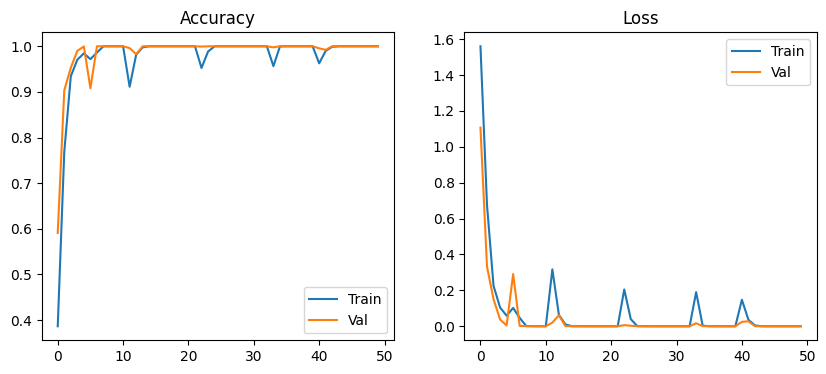

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Classification Report:
               precision    recall  f1-score   support

       Anger       1.00      1.00      1.00      2235
     Disgust       1.00      1.00      1.00      1856
        Fear       1.00      1.00      1.00      2264
       Happy       1.00      1.00      1.00      1604
     Neutral       1.00      1.00      1.00      1322
         Sad       1.00      1.00      1.00      2438
    Surprise       1.00      1.00      1.00      2230

    accuracy                           1.00     13949
   macro avg       1.00      1.00      1.00     13949
weighted avg       1.00      1.00      1.00     13949



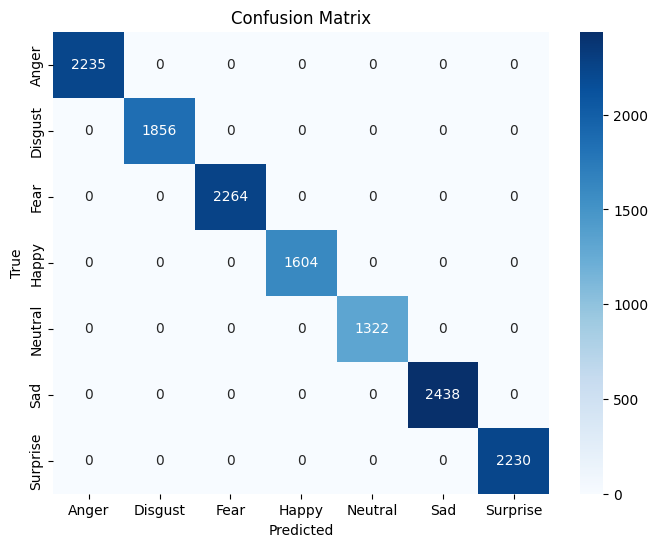

In [12]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



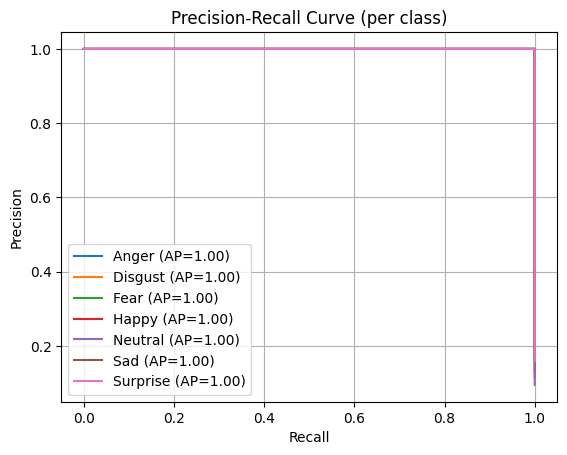

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    ap_score = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'{class_name} (AP={ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (per class)")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(class_accuracy):
    print(f"{le.classes_[idx]} Accuracy: {acc:.2%}")


Anger Accuracy: 100.00%
Disgust Accuracy: 100.00%
Fear Accuracy: 100.00%
Happy Accuracy: 100.00%
Neutral Accuracy: 100.00%
Sad Accuracy: 100.00%
Surprise Accuracy: 100.00%


In [32]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

def top_k_accuracy(y_true, y_pred, k=3):
    return np.mean(top_k_categorical_accuracy(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred), k=k).numpy())

print("Top-1 Accuracy:", top_k_accuracy(y_test, y_pred, k=1))
print("Top-3 Accuracy:", top_k_accuracy(y_test, y_pred, k=3))


Top-1 Accuracy: 1.0
Top-3 Accuracy: 1.0


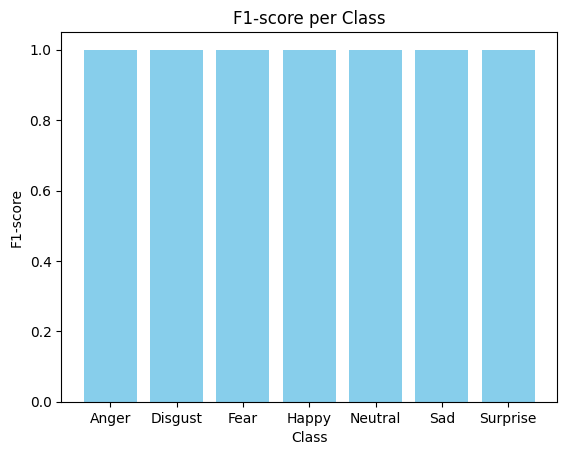

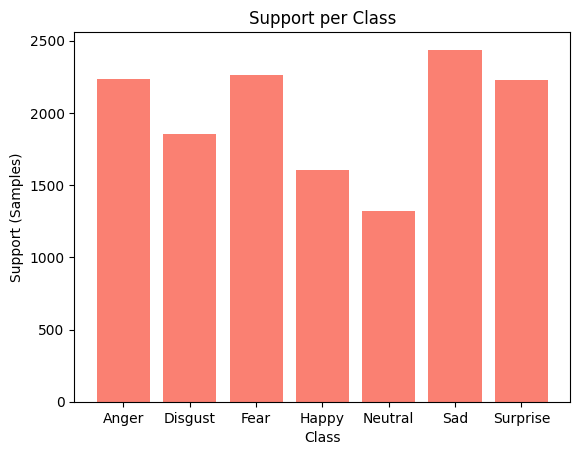

In [33]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

report = classification_report(y_true_labels, y_pred_labels, target_names=le.classes_, output_dict=True)
f1s = [report[label]['f1-score'] for label in le.classes_]
supports = [report[label]['support'] for label in le.classes_]

plt.bar(le.classes_, f1s, color='skyblue')
plt.ylabel('F1-score')
plt.xlabel('Class')
plt.title('F1-score per Class')
plt.show()

plt.bar(le.classes_, supports, color='salmon')
plt.ylabel('Support (Samples)')
plt.xlabel('Class')
plt.title('Support per Class')
plt.show()


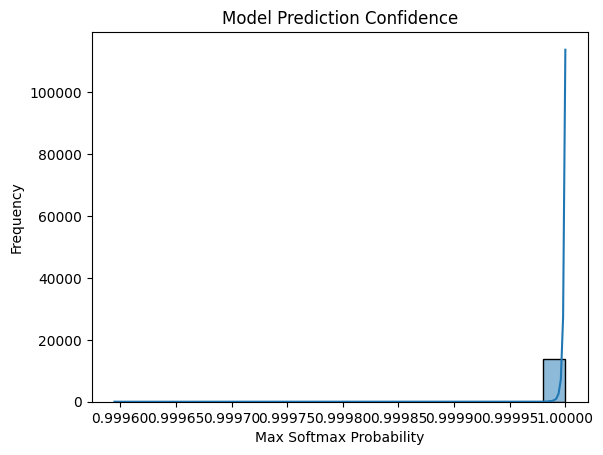

In [34]:
import seaborn as sns

confidences = np.max(y_pred, axis=1)
sns.histplot(confidences, bins=20, kde=True)
plt.title("Model Prediction Confidence")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.show()


In [35]:
import numpy as np

most_confused = np.unravel_index(np.argmax(cm - np.eye(len(le.classes_)) * cm.max()), cm.shape)
print(f"Most confused: {le.classes_[most_confused[0]]} predicted as {le.classes_[most_confused[1]]}")


Most confused: Anger predicted as Disgust


In [13]:
model.save("eeg_emotion_gan_model.h5")
with open('eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Model and preprocessors saved.")

Model and preprocessors saved.


In [14]:
!pip install flask
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 22 packages in 2s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇

In [15]:
!pip install flask flask-ngrok tensorflow joblib pykalman scipy

from flask import Flask, jsonify
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter
import subprocess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.0 MB/s eta 0:00:00


In [40]:
app = Flask(__name__)

# Setup for your EEG signal processing
sampling_rate_original = 2500
sampling_rate_final = 200
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

def extract_de_lds():
    eeg_data = generate_eeg()
    de_feats = []
    for ch in eeg_data:
        ch = downsample(ch, sampling_rate_original, sampling_rate_final)
        band_feats = []
        for _, (low, high) in freq_bands.items():
            filtered = bandpass_filter(ch, low, high, sampling_rate_final)
            var = np.var(filtered)
            de = 0.5 * np.log(2 * np.pi * np.e * var + 1e-8)
            band_feats.append(de)
        smoothed, _ = kf.filter(np.array(band_feats).reshape(-1, 1))
        de_feats.append(smoothed.flatten())
    de_feats = np.array(de_feats)
    de_min, de_max = np.min(de_feats), np.max(de_feats)
    scaled = 15 + (de_feats - de_min) / (de_max - de_min + 1e-8) * (27 - 15)
    return scaled.flatten()

# @app.route('/predict', methods=['GET'])
# def predict():
#     sample = extract_de_lds().reshape((1, 1,310))
#     model = load_model('eeg_emotion_gan_model.h5')
#     encoder = joblib.load('eeg_label_encoder.pkl')
#     prediction = model.predict(sample)
#     # print(f"Model Prediction: {prediction}")

#     label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]
#     print(f"Predicted Emotion: {label}")
#     return jsonify({'emotion': label})

@app.route('/predict', methods=['GET'])
def predict():
    sample = extract_de_lds().reshape((1, 1, 310))
    model = load_model('eeg_emotion_gan_model.h5')
    encoder = joblib.load('eeg_label_encoder.pkl')

    prediction = model.predict(sample)[0]  # Shape: (num_classes,)
    predicted_index = np.argmax(prediction)
    label = encoder.inverse_transform([predicted_index])[0]
    confidence = prediction[predicted_index]

    # Get top 3 predictions
    top_indices = prediction.argsort()[-3:][::-1]
    top_labels = encoder.inverse_transform(top_indices)
    top_confidences = prediction[top_indices]

    # Print to terminal
    print(f"\nPredicted Emotion: {label}")
    print(f"Confidence: {confidence:.4f}")
    print("Top 3 Predictions:")
    for i in range(3):
        print(f"  {top_labels[i]}: {top_confidences[i]:.4f}")

    # Return as JSON response
    return jsonify({
        'emotion': label,
        'confidence': round(float(confidence), 4),
        'top_3_predictions': [
            {'label': top_labels[i], 'confidence': round(float(top_confidences[i]), 4)}
            for i in range(3)
        ]
    })


# Run LocalTunnel to expose the Flask API with a custom subdomain for static URL
def run_localtunnel():
    subdomain = "eegemotion"  # Replace with your desired subdomain
    process = subprocess.Popen(['lt', '--port', '5000', '-s', subdomain], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode('utf-8').strip())  # Show the URL output from LocalTunnel

# Start the LocalTunnel process and Flask app
if __name__ == "__main__":
    from threading import Thread
    # Run LocalTunnel in a separate thread
    thread = Thread(target=run_localtunnel)
    thread.start()
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt
